In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Portfolio optimization in practice
---

If one could reliably predict future returns, one would not need or seek diversification; one would instead invest in the highest returning asset at each point in time. Crystal balls, however, hardly exist in the real world, and this is the reason why investors should instead hold well-diversified portfolios. Well-diversified portfolios are scientifically defined as portfolios that deliver the highest reward for a given risk budget. In the absence of parameter uncertainty, and if volatility is used as a risk measure, this leaves us with a simple prescription, namely maximize the Sharpe ratio. 

This definition, however, is not fully operational because of the presence of parameter uncertainty. In this context, one can turn to naive diversification, which focuses on the question of how to construct a **well-diversified** portfolio (mean goal) as a proxy for constructing a **well-rewarded** portfolio (end goal). 

While naive diversification is often taken to imply an equally-weighted portfolio, the approach can be extended to imply an equal allocation in terms of contributions from underlying factors to the risk of the portfolio. In this module, we explore practical issues in the implementation well-diversified portfolios and we work through the mechanics of various portfolio optimization methodologies and discuss their pros and cons in applications to the construction of improved equity benchmarks. 


## How to measure the degree of diversification?

The total number of assets in a portfolio does not necessarily reflect the degree of diversification of the porfolio, because some assets might have a much higher concentration than others. It is thus needed a mathematical way to measure that, which is given by the following expression.

### Effective Number of Constituents (ENC)


$$ENC = \left( \sum_{i=1}^N w_i^2\right)^{-1}$$

ENC is between 1 (when the portfolio is fully concentrated) and N (when all assets are equally-weighted). So another way to look at the EW portfolio es to think of it as the max-ENC portfolio.

Take the S&P 500, for instance. The nominal number of constituents is 500, but the effective number is around 100.

# Scientific diversification

## 1. Maximum Sharpe Ratio

The best possible porfolio that an investor would want to hold is the MSR portfolio, which is the one that provides the higher excess return per unit of risk. The problem of this portfolio is that it is very difficult (if not imposible) to find, because of estimation error on both expected returns and variance. We have seen that variance estimates are easier to become robust by implementing some shrinking methodologies, while dealing with expected returns is much harder. That is why another good choice for a portfolio is the one with the minimum variance.

## 2. Global Minimum Variance

A very remarkable portfolio that, while not the most optimal, still lies on the efficient frontier, is the GMV portfolio. This portfolio solves the problem of minimizing the risk of the portfolio, and it is very appealing from a practical point, because there is not need to estimate expected returns. 

The problem with GMV porfolio is that the underlying assumption needed is that all expected returns are equal, which is clearly not a very realistic assumption.
The GMV tends to overweight those assets with low volatility, which results into a very concentrated portfolio. 

There is some solutions to ensure that the GMV is well-balanced:

- 1. Minimize Global Variance subject to a minimum ENC

- 2. Assume all assets have the same volatility: max decorrelation portfolio


## 3. Risk contributions

Even a portfolio with a high ENC that looks well-balanced in terms of dollar allocation, may not be well-balanced in terms of risk allocation.

Assume we have a two-assets porfolio: a stock with volatility of 30% and a bond with 10% volatility. Further asusme that the correlation between the two is 0 and that we allocate 50% in each asset.

The variance of the portfolio will be:

$$\sigma_p^2 = \sigma_1^2 \omega_1^2 + \sigma_2^2 \omega_2^2$$

$$\sigma_p^2 = 0.3^2\times 0.5^2 + 0.1^2\times 0.5^2 = 0.025$$

Each term of the right hand side of the equation corresponds to the contribution of the asset to the risk of the portfolio. We thus have:

$$p_1 = \frac{0.3^2\times 0.5^2}{0.025} = 90\%$$

$$p_2 = \frac{0.1^2\times 0.5^2}{0.025} = 10\%$$

If we now assume that the assets are correlated, with $\rho = 0.25$, the variance of the portfolio will be:

$$\sigma_p^2 = \sigma_1^2 \omega_1^2 + \sigma_2^2 \omega_2^2 + 2 \omega_1\omega_2\rho\sigma_1\sigma_2$$

$$\sigma_p^2 = 0.3^2 \times 0.5^2 + 0.1^2 \times  0.5^2 + 2\times 0.5\times 0.5\times 0.25\times 0.30\times 0.10 = 0.0288$$


How can we now measure  the risk contribution of each asset? How to allocate the correlated component? The most common way to do it is to split the correlated component in two, and assing half to each asset. Risk contributions now become:

$$p_1 = \frac{0.3^2\times 0.5^2 + 0.5\times 0.5\times 0.25\times 0.30\times 0.10}{0.025} = 85\%$$

$$p_2 = \frac{0.1^2\times 0.5^2 + 0.5\times 0.5\times 0.25\times 0.30\times 0.10}{0.025} = 15\%$$


**Risk Parity** portfolio, also known as the **Equal Risk Contribution** (ERC) portfolio is that porfolio in which the risk contribution of each asset to the total risk of the portfolio is equal. It is the portfolio that maximizes the ENC computed with $\omega_i$ as the risk contribution, rather than the dollar contribution. This ENC is known as the **Effective Number of Correlated Bets (ENCB)**

When there is only 2 assets, the weight assigned to each one is inversely proportional to its volatility. When there is more than two assets, this is only true if all pairwise correlations between assets are equal. 

Risk parity portfolios have become extremely popular in practice as a way to build well-balanced portfolio with a focus on risk analysis at the overall portfolio level. 

# Risk Parity Portfolio

Given the portfolio variance:

$$\sigma_p^2 = \sum_{i = 1}^N \sum_{j = 1}^N \omega_i\omega_j\sigma_{ij} = \sum_{i=1}^N \omega_i^2\sigma_i^2 + \sum_{i = 1}^N \sum_{j \neq i}^N \omega_i\omega_j\sigma_{ij}$$

Then the risk contribution of each asset is equal to:

$$p_i = \frac{\omega_i^2 \sigma_i^2 \sum_{j \neq i}^N \omega_i\omega_j\sigma_{ij}}{\sigma_p^2}$$

Then the ENCB is:

$$ENCB = \left(\sum_{i=1}^N p_i^2 \right)^{-1}$$

The risk partity porfolio is such that the ENCB is maximum.
Except for the case in which all correlations are equal, there is no mathematical expression for the risk parity weights. We will find them through some optimization method.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc("font",family="serif")
plt.rc("font",size=15)

import functions as f
import seaborn as sns
palette = sns.color_palette('CMRmap', 5)

inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = f.get_ind_returns()["1974":]
ind_mcap = f.get_ind_market_caps()["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

C:\Users\jsaul\Dropbox\gdp-trabajos-ana\Notebooks\Portfolio Construction with Python\Ana\2. Advanced Portfolio Construction\functions.py:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
C:\Users\jsaul\Dropbox\gdp-trabajos-ana\Notebooks\Portfolio Construction with Python\Ana\2. Advanced Portfolio Construction\functions.py:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
C:\Users\jsaul\Dropbox\gdp-trabajos-ana\Notebooks\Portfolio Construction with Python\Ana\2. Advanced Portfolio Construction\functions.py:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


In [3]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio
    w: portfolio weights
    cov: covariance matrix
    """
    total_portfolio_var = f.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

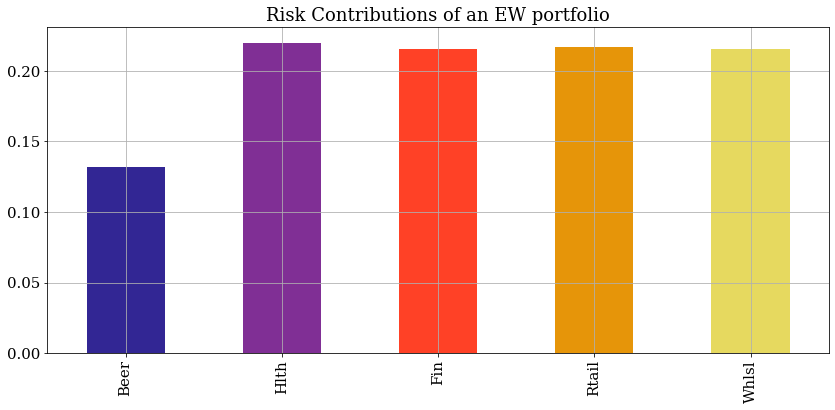

In [4]:
risk_contribution(f.weight_ew(rets), cov).plot.bar(figsize = (14,6), title="Risk Contributions of an EW portfolio", grid = True, color = palette)

In [5]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


In [6]:
equal_risk_contributions(cov).sort()

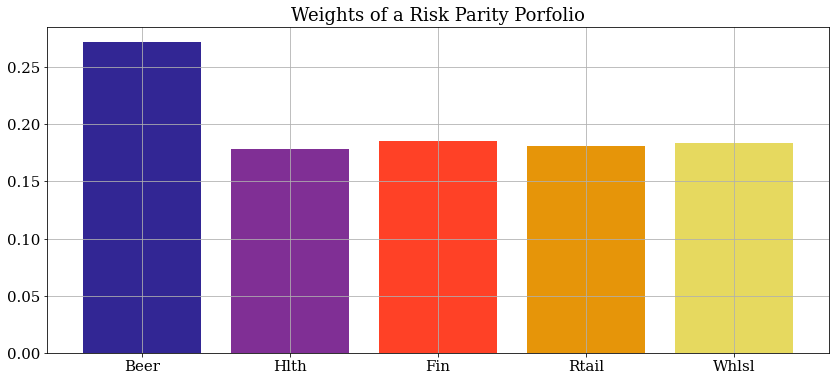

In [7]:
plt.figure(figsize = (14,6))
plt.bar(cov.index, equal_risk_contributions(cov), color = palette)
plt.title('Weights of a Risk Parity Porfolio')
plt.grid()

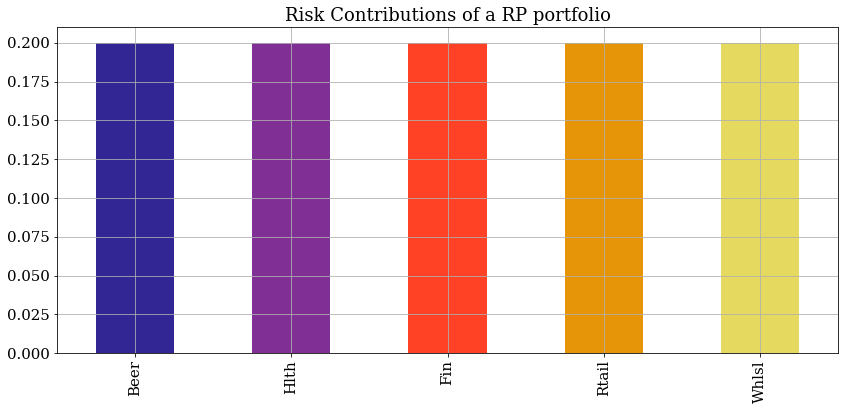

In [8]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(figsize = (14,6), title="Risk Contributions of a RP portfolio", grid = True, color = palette)

Let's now backtest this portfolio.

In [9]:
def weight_erc(r, cov_estimator=f.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.118454,0.157971,-0.759350,6.474680,0.070650,0.102488,0.544802,-0.53298
CW,0.117158,0.149731,-0.698677,5.370407,0.066919,0.096791,0.566382,-0.51899


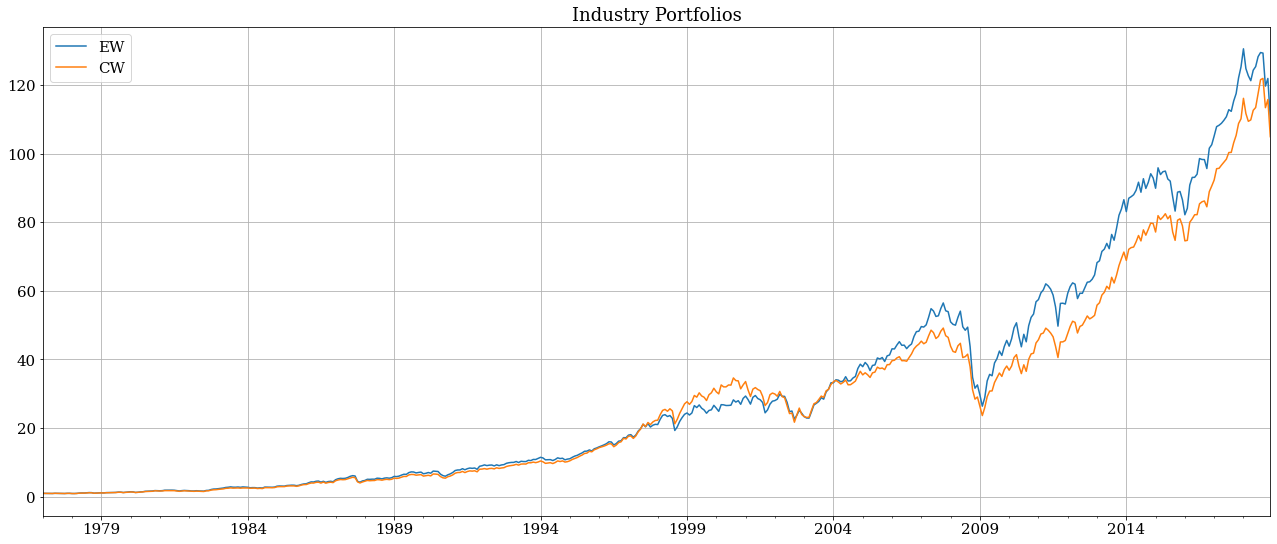

In [13]:
ewr = f.backtest_ws(ind_rets, estimation_window=36, weighting=f.weight_ew)
cwr = f.backtest_ws(ind_rets, estimation_window=36, weighting=f.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr}).dropna()
(1+btr).cumprod().plot(figsize=(22,9), title="Industry Portfolios", grid = True)
f.summary_stats(btr)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.118454,0.157971,-0.759350,6.474680,0.070650,0.102488,0.544802,-0.532980
CW,0.117158,0.149731,-0.698677,5.370407,0.066919,0.096791,0.566382,-0.518990
ERC-Sample,0.118637,0.146210,-0.832054,6.751046,0.065296,0.094536,0.589879,-0.499481


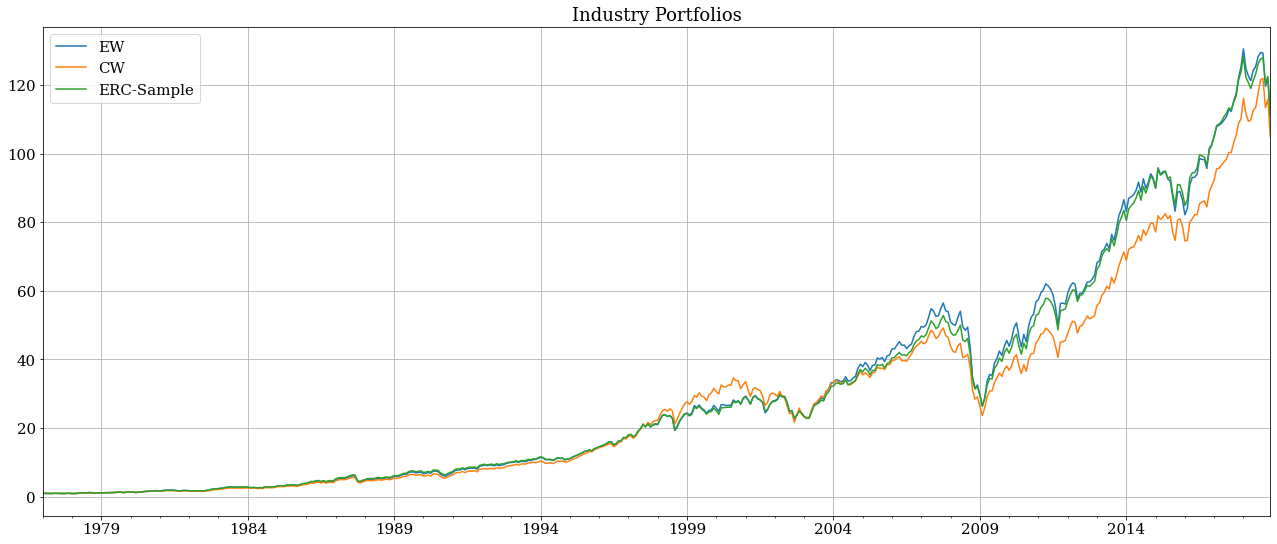

In [14]:
mv_erc_r = f.backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=f.sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r}).dropna()
(1+btr).cumprod().plot(figsize=(22,9), title="Industry Portfolios", grid=True)
f.summary_stats(btr)